If I don't prevent OpenMP threading, I end up with a *ton* of system time from multithreaded BLAS that actually lowers performance:

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import arviz as az
from emcee import EnsembleSampler
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
import scipy.linalg as sl
import scipy.stats as ss
import starry
from starry import Map, System, Primary, Secondary
import starry_process
from starry_process import StarryProcess
import theano
import theano.tensor as tt
from theano.tensor.random.utils import RandomStream
from tqdm.notebook import tqdm

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [156]:
def _cho_solve(L, b):
    return tt.slinalg.solve_upper_triangular(L.T, tt.slinalg.solve_lower_triangular(L, b))

class LinearInterpolatedStarryStarryProcess(object):
    def __init__(self, sys, sp, nt, nlm, num_maps):
        self._sys = sys
        self._sp = sp
        self._nt = nt
        self._nlm = nlm
        self._num_maps = num_maps

        self._mu = tt.concatenate([sp.mean_ylm]*num_maps)
        C = sp.cov_ylm
        self._Lambda = tt.zeros((num_maps*nlm, num_maps*nlm))
        for i in range(num_maps):
            start_idx = i*nlm
            end_idx = (i+1)*nlm
            self._Lambda = tt.set_subtensor(self._Lambda[start_idx:end_idx, start_idx:end_idx], C)

    @property
    def nt(self):
        return self._nt
    @property
    def nlm(self):
        return self._nlm
    
    @property
    def num_maps(self):
        return self._num_maps

    @property
    def sys(self):
        return self._sys
    @property
    def sp(self):
        return self._sp
    
    @property
    def mu(self):
        return self._mu
    @property
    def Lambda(self):
        return self._Lambda
    
    @property
    def primary(self):
        return self.sys.primary
    @property
    def secondary(self):
        return self.sys.secondaries[0]
    
    @property
    def design_matrix(self):
        return self._M

    @property
    def logl_marginal(self):
        return self._logl_marginal
    @property
    def a(self):
        return self._a
    @property
    def AInv_chol(self):
        return self._AInv_chol

    def _compute(self, t, flux, sigma_flux):
        num_maps = self.num_maps
        nt = self.nt
        nlm = self.nlm

        MM = self.sys.design_matrix(t)[:, :-1]  # We don't use any flux from the secondary, so [:, :-1]

        T0 = t[0]
        T1 = t[nt // (num_maps-1)]
        interval = nt // (num_maps-1)
        T2 = t[-1]

        # Linear interpolation coefficients for the first map
        phi0 = (t[:interval] - T1) / (T0 - T1)
        coefficients_map01 = np.stack([phi0, 1 - phi0, np.zeros_like(phi0)], axis=1)

        # Linear interpolation coefficients for the second map
        phi1 = (t[interval:] - T2) / (T1 - T2)
        coefficients_map12 = np.stack([np.zeros_like(phi1), phi1, 1 - phi1], axis=1)

        M1 = np.vstack([MM.eval()[:interval,:].T * coefficients_map01[:,0], MM.eval()[:interval,:].T * coefficients_map01[:,1], MM.eval()[:interval,:].T * coefficients_map01[:,2]])
        M2 = np.vstack([MM.eval()[interval:,:].T * coefficients_map12[:,0], MM.eval()[interval:,:].T * coefficients_map12[:,1], MM.eval()[interval:,:].T * coefficients_map12[:,2]])

        M = np.hstack([M1, M2]).T


        self._M = M

        mu = self.mu
        Lambda = self.Lambda

        # We want to enforce that the prior on the constant term in the map is
        # completely flat, so we set the first row and column of the precision
        # matrix to zero we do this manually here.  First we Cholesky decompose:
        #
        # Lambda[1:,1:] = L L^T
        #
        # Then, because of a quirk of theano (no gradients for `cho_solve!`,
        # WTF), we can compute Lambda[1:,1:]^{-1} via
        #
        # Lambda[1:,1:]^{-1} = tt.slinalg.solve_triangular(L.T, tt.slinalg.solve_triangular(L, tt.eye(nlm-1), lower=True), lower=False)
        #
        # encapsulated in our _cho_solve(...) function above

        # Also: the covariance matrix contains a "double-copy" of the starry
        # process covariance: CC = [[C, 0], [0, C]], and we only have to solve
        # one of them, and then can reconstruct the inverse as 
        # CC^{-1} = [[C^{-1}, 0], [0, C^{-1}]].

        L = tt.slinalg.cholesky(Lambda[1:nlm,1:nlm])
        Lambda_inv = _cho_solve(L, tt.eye(nlm-1))
        Lambda_inv = tt.set_subtensor(tt.zeros((nlm, nlm))[1:,1:], Lambda_inv)

        Lambda_inv = tt.set_subtensor(tt.zeros((3 * nlm, 3 * nlm))[:nlm, :nlm], Lambda_inv)
        Lambda_inv = tt.set_subtensor(Lambda_inv[nlm:2 * nlm, nlm:2 * nlm], Lambda_inv[:nlm, :nlm])
        Lambda_inv = tt.set_subtensor(Lambda_inv[2 * nlm:, 2 * nlm:], Lambda_inv[:nlm, :nlm])

        sigma_flux2 = tt.square(sigma_flux)
        MTCinv = M.T / sigma_flux2[None, :]
        MTCinvM = tt.dot(MTCinv, M)

        AInv = Lambda_inv + MTCinvM
        AInv_chol = tt.slinalg.cholesky(AInv)
        a = _cho_solve(AInv_chol, tt.dot(Lambda_inv, mu) + tt.dot(MTCinv, flux))

        self._a = a
        self._AInv_chol = AInv_chol

        b = tt.dot(M, mu)
        r = flux - b

        Cinvr = r / sigma_flux2

        rtilde = Cinvr - tt.dot(MTCinv.T, tt.slinalg.solve(AInv, tt.dot(MTCinv, r)))

        # Identity:
        # |B| = |I + M^T C^-1 M L| |C| = |L^-1 + M^T C^-1 M| |L| |C|
        # But we want to cancel the infinite constant in L[0,0], so we ignore the first row and column of L:
        # |B| = | A^-1 | |L[1:,1:]| |C|
        # The "4" below comes because we have *two* copies of the covariance matrix for starry process in the full covariance matrix.

        logdetB = tt.sum(tt.log(sigma_flux2)) + 2*tt.sum(tt.log(tt.diag(AInv_chol))) + 2*num_maps*tt.sum(tt.log(tt.diag(L)))

        # (nt-2) because we have cancelled two dimensions due to the flat prior
        # on the [0,0] constant term in each of the interpolant maps.
        logl = -0.5*tt.dot(r, rtilde) - 0.5*logdetB - 0.5*(nt-2)*tt.log(2*np.pi)
        self._logl_marginal = logl

    def marginal_likelihood(self, t, flux, sigma_flux):
        self._compute(t, flux, sigma_flux)
        return self.logl_marginal
    
    def sample_ylm_conditional(self, t, flux, sigma_flux, size=1, rng=None):
        if rng is None:
            rng = RandomStream(seed=np.random.randint(1<<32))

        nylm = self.nlm

        self._compute(t, flux, sigma_flux)
        return self.a[None,:] + tt.slinalg.solve_upper_triangular(self.AInv_chol.T, rng.normal(size=(self.num_maps * nylm, size))).T

In [139]:
starry.config.lazy = True

ydeg = 15
udeg = 2

u1 = 0.4
u2 = 0.26

r = 20.0
dr = 5.0
n = 1
c = 0.5
mu = 30.0
sigma = 5.0

prot = 30.0
porb = 4.887802443

stellar_inc = 90.0
stellar_obl = -30.0

rng = np.random.default_rng(302592346730275158208684369480422136411)

pri = Primary(starry.Map(ydeg, udeg=udeg, inc=stellar_inc, obl=stellar_obl),
              r=0.683, m=0.81, prot=prot, t0=0.0)
sec = Secondary(starry.Map(0, 0), 
                t0=0, r=0.04*pri.r.eval(), m=1e-3*pri.m.eval(), prot=1.0,
                porb=porb, ecc=0.0, Omega=0, inc=90)
pri.map[1] = u1
pri.map[2] = u2

sys = System(pri, sec)

Ttr_half = 0.1
dt_in_transit = Ttr_half / 20.0
dt_out_transit = prot / 20.0

sp = StarryProcess(n=n, mu=mu, sigma=sigma, r=r, dr=dr, ydeg=ydeg, udeg=udeg, marginalize_over_inclination=False, seed=rng.integers(0, 1<<32))

y0_true = sp.sample_ylm().eval()[0,:]
y1_true = sp.sample_ylm().eval()[0,:]
y3_true = sp.sample_ylm().eval()[0,:]
y0_true[0] = 1.0
y1_true[0] = 1.02
y3_true[0] = 0.8

T = 3*prot
t_in = np.arange(-T, T, dt_in_transit)
t_out = np.arange(-T, T, dt_out_transit)

t_in_transit = (t_in % sec.porb.eval() < Ttr_half) | (t_in % sec.porb.eval() > sec.porb.eval()-Ttr_half)
t_out_transit = (t_out % sec.porb.eval() < Ttr_half) | (t_out % sec.porb.eval() > sec.porb.eval()-Ttr_half)

t = np.sort(np.concatenate((
    t_in[t_in_transit],
    t_out[~t_out_transit],
)))
nt = len(t)

ssp = LinearInterpolatedStarryStarryProcess(sys, sp, nt, len(pri.map.y.eval()), num_maps=3)
ssp._compute(t, np.zeros_like(t), np.ones_like(t))

flux_true = ssp.design_matrix @ np.concatenate((y0_true, y1_true, y3_true))
sigma_flux = 1e-4*np.ones_like(flux_true)

flux_obs = flux_true + sigma_flux*rng.normal(size=nt)

Pre-computing some matrices... Done.


Pre-computing some matrices... Done.


(256, 798)
(768, 768)


In [140]:
ssp.design_matrix.shape

(1597, 768)

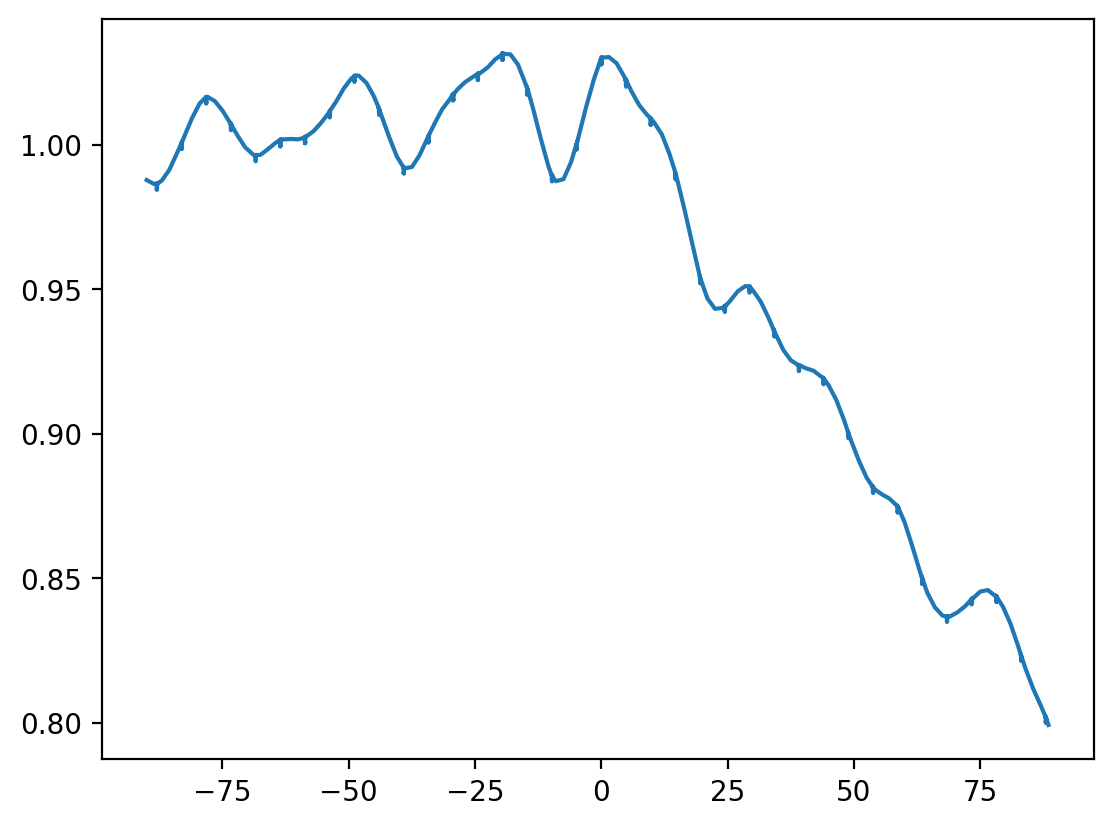

In [141]:
plt.plot(t, flux_obs)

In [120]:
len(t)

1597

/Users/sabina/Desktop/GitHub/starry_process/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


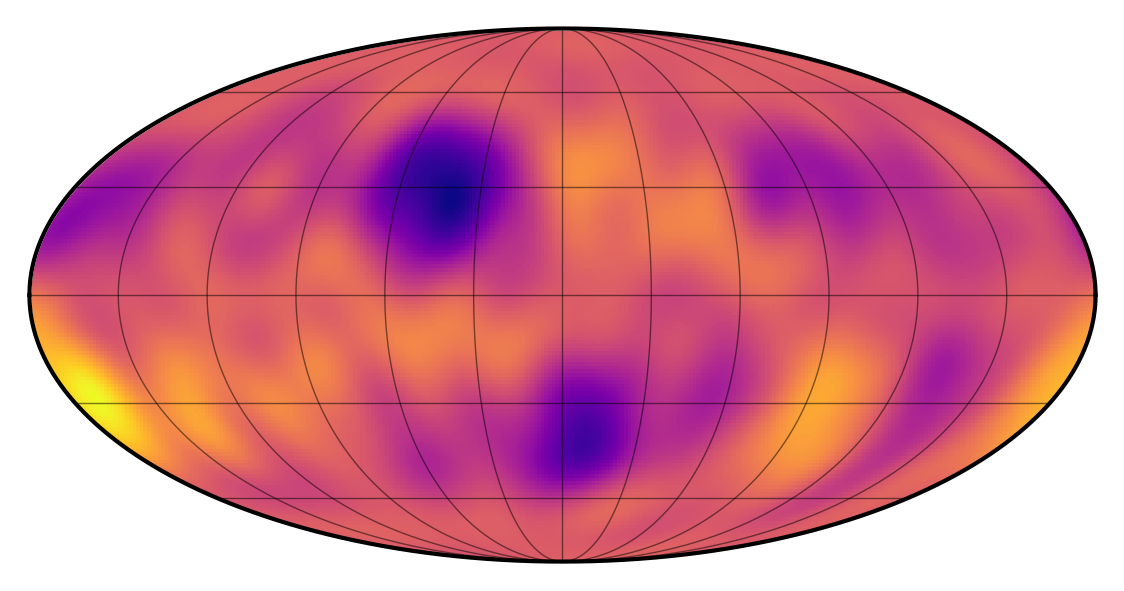

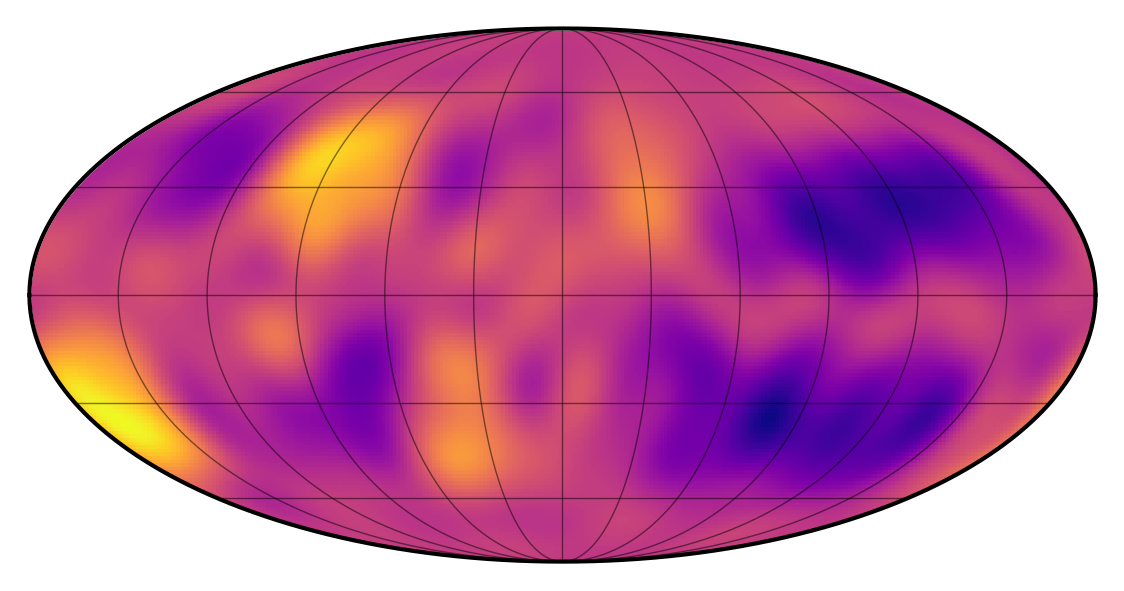

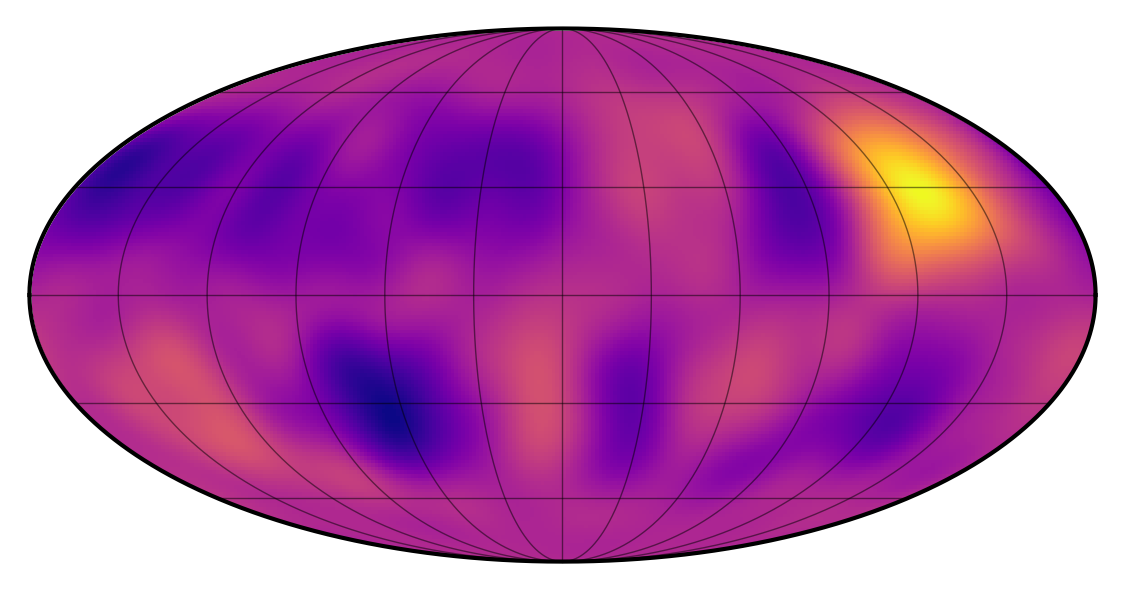

In [121]:
sp.visualize(y0_true)
sp.visualize(y1_true)
sp.visualize(y3_true)

/Users/sabina/Desktop/GitHub/starry_process/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


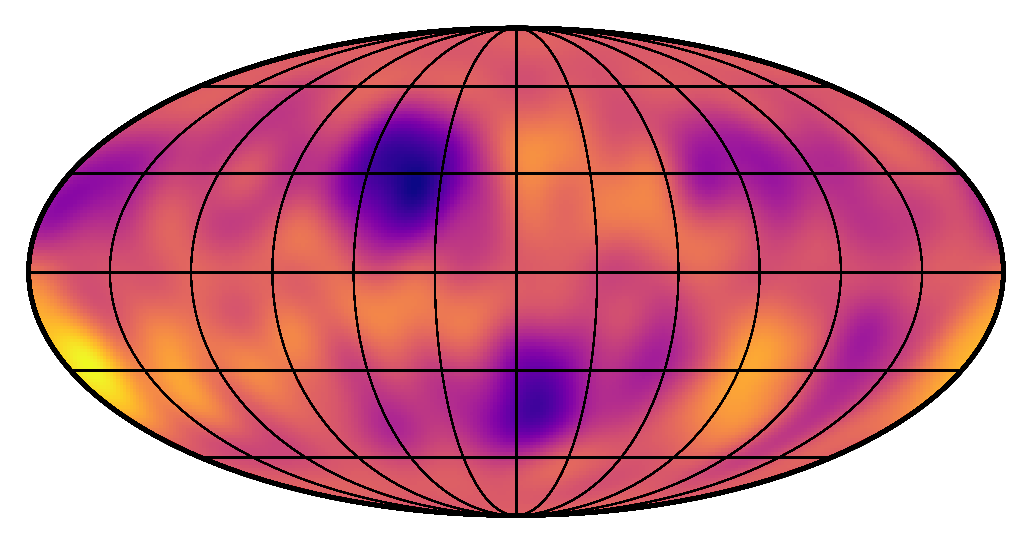

In [155]:
t_interp_1 = np.linspace(t[0], t[nt//2], 50)  
t_interp_2 = np.linspace(t[nt//2], t[-1], 50)  

fig = plt.figure()
ax = plt.gca()

def frame(i):
    if i < len(t_interp_1):
        ti = t_interp_1[i]
        t0 = t[0]
        t1 = t[nt//2]
        y = (ti - t1) / (t0 - t1) * y0_true + (ti - t0) / (t1 - t0) * y1_true
    else:
        ti = t_interp_2[i - len(t_interp_1)]
        t0 = t[nt//2]
        t1 = t[-1]
        y = (ti - t1) / (t0 - t1) * y1_true + (ti - t0) / (t1 - t0) * y3_true

    sp.visualize(y, ax=ax)
    return fig

t_interp = np.concatenate((t_interp_1, t_interp_2))
ani = FuncAnimation(fig, frame, frames=len(t_interp), interval=100)
ani.save("/Users/sabina/Downloads/ssp.mp4")

<ErrorbarContainer object of 3 artists>

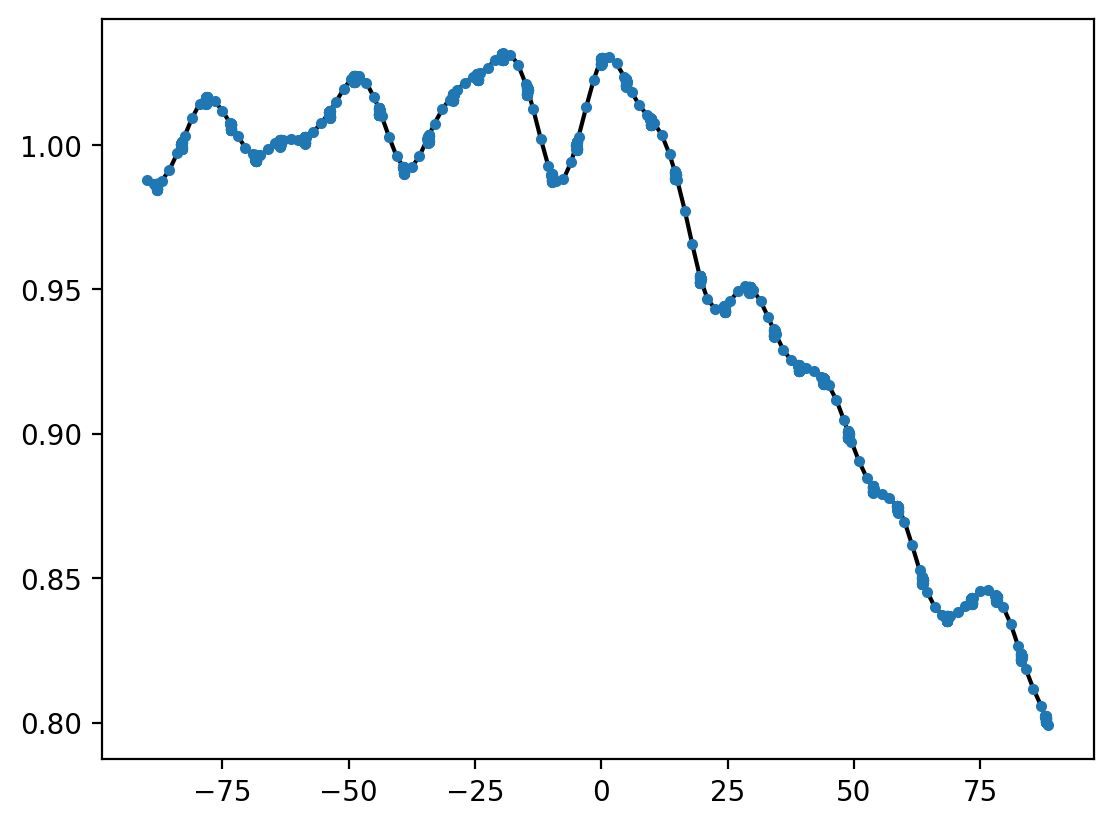

In [122]:
plt.plot(t, flux_true, color='k')
plt.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.')

<ErrorbarContainer object of 3 artists>

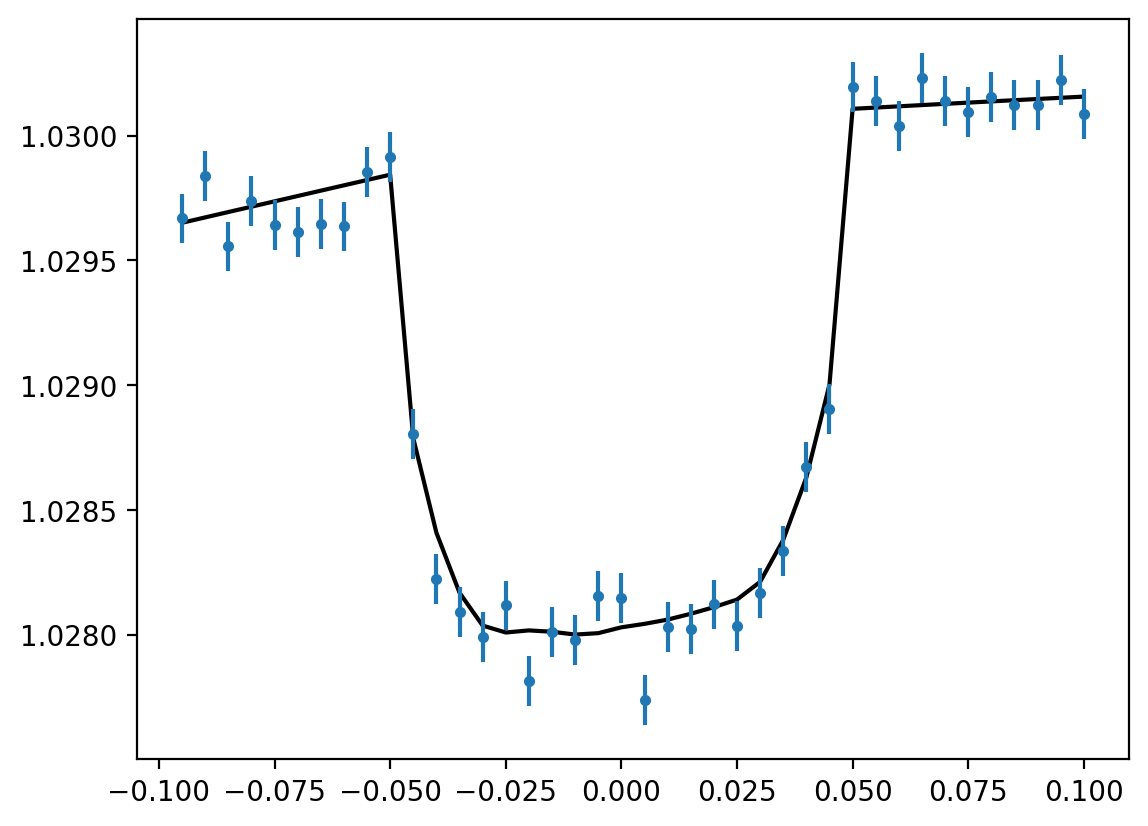

In [142]:
sel = np.abs(t) < sec.porb.eval()/10
plt.plot(t[sel], flux_true[sel], color='k')
plt.errorbar(t[sel], flux_obs[sel], yerr=sigma_flux[sel], fmt='.')

In [126]:
flux_obs.shape

(1597,)

In [143]:
ylm_draw = ssp.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]

(256, 798)
(768, 768)


/Users/sabina/Desktop/GitHub/starry_process/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


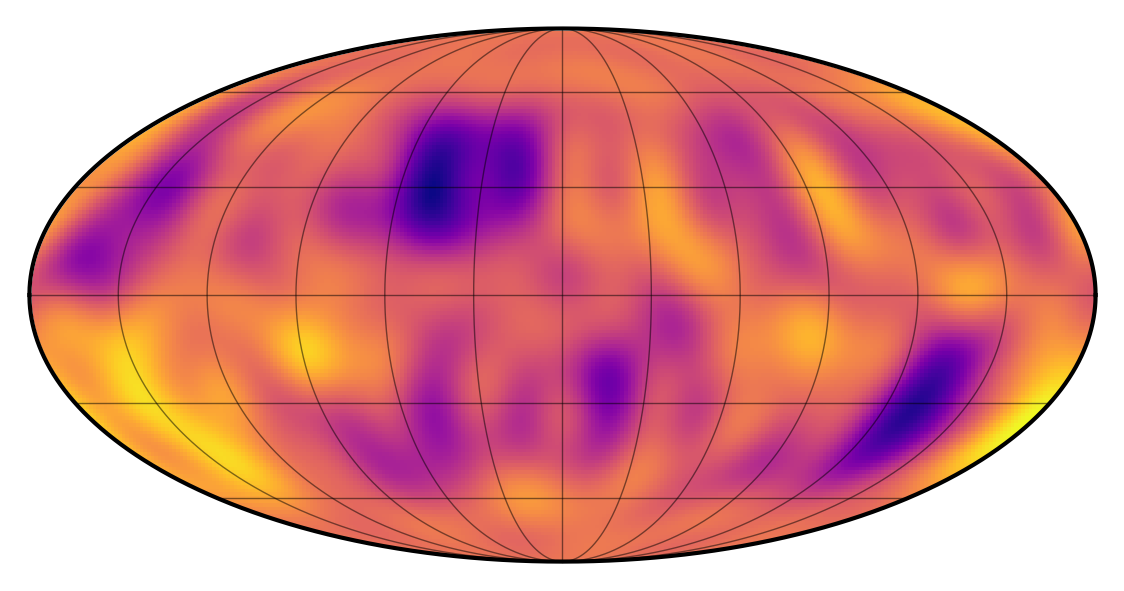

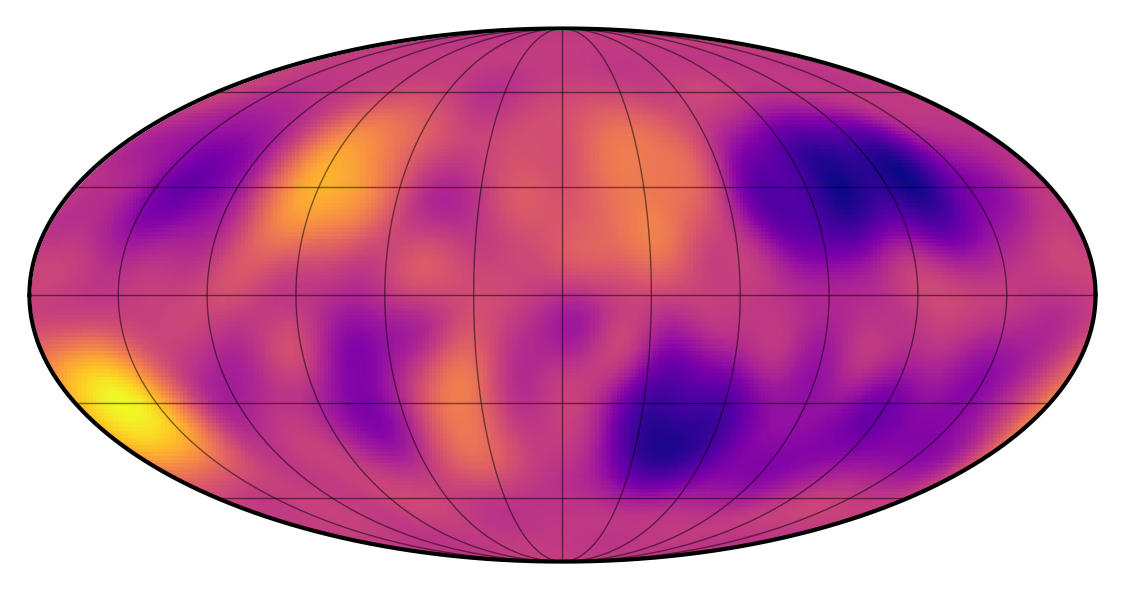

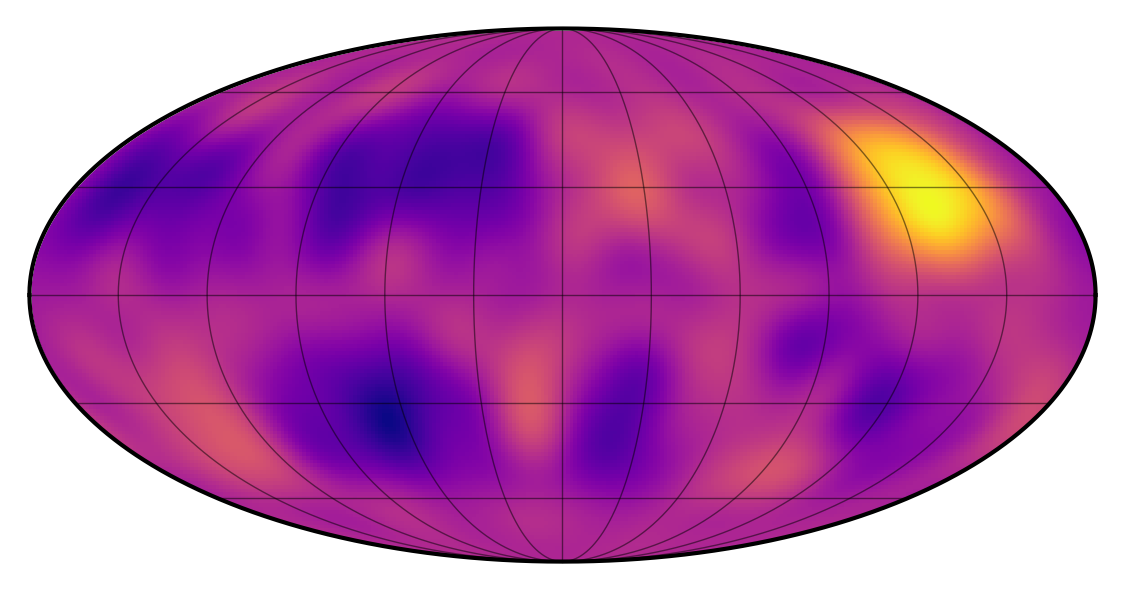

In [145]:
sp.visualize(ylm_draw[:ssp.nlm])
sp.visualize(ylm_draw[ssp.nlm:2*ssp.nlm])
sp.visualize(ylm_draw[2*ssp.nlm:])

/Users/sabina/Desktop/GitHub/starry_process/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


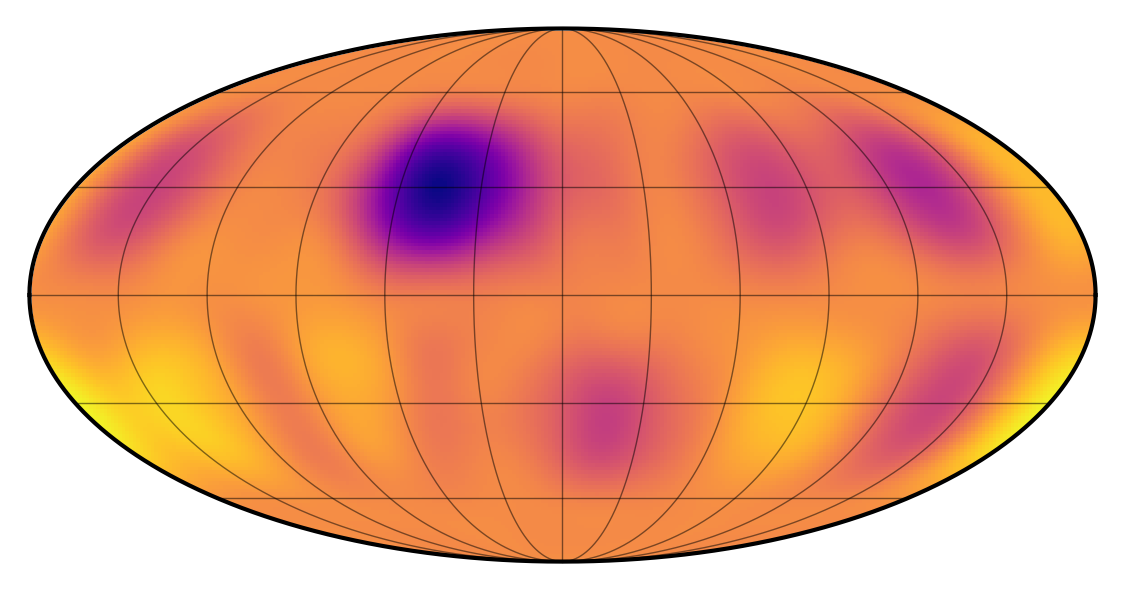

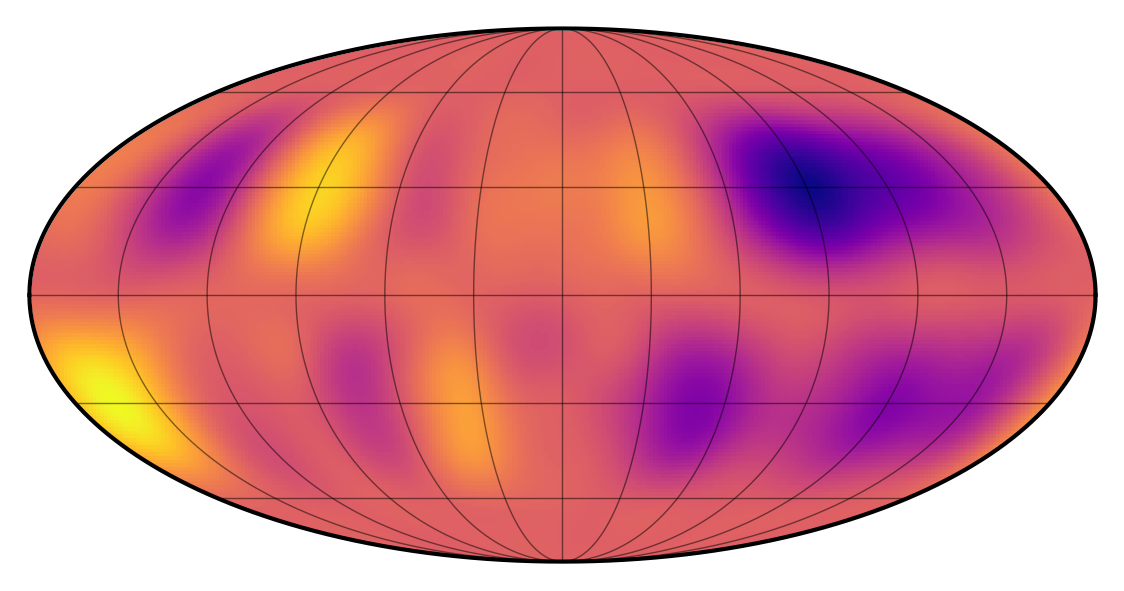

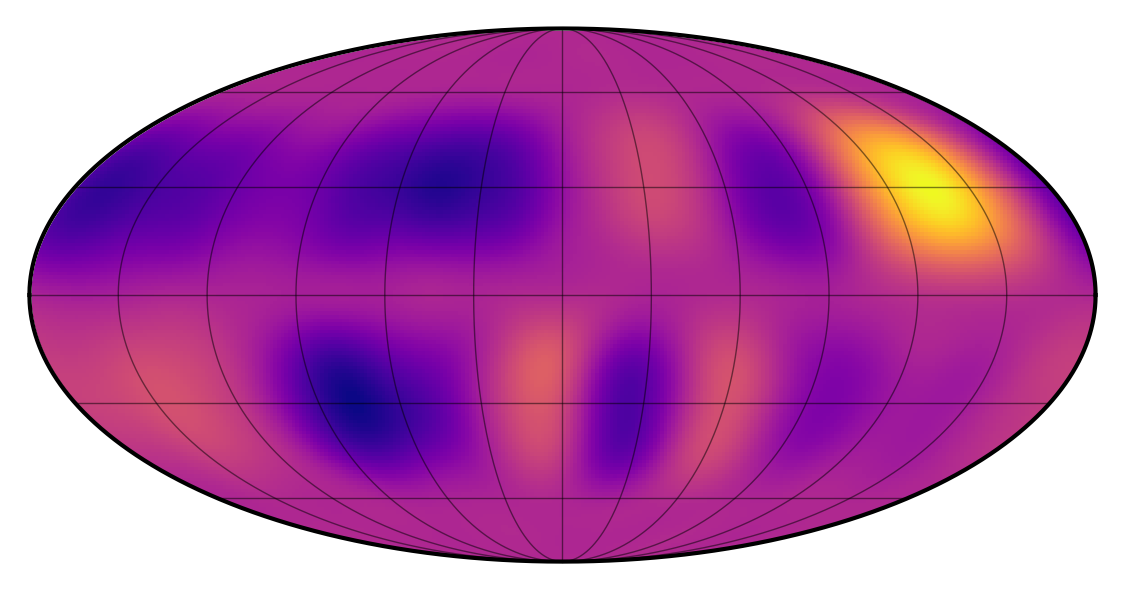

In [147]:
sp.visualize(ssp.a.eval()[:ssp.nlm])
sp.visualize(ssp.a.eval()[ssp.nlm:2*ssp.nlm])
sp.visualize(ssp.a.eval()[2*ssp.nlm:])

## Everything above here works, below here there are various problems with sizes.

Let's double-check the Gaussian factorization; the next two cells should give identical log-likelihoods:

In [148]:
flux_obs.shape

(1597,)

In [150]:
resid = flux_obs - ssp.design_matrix @ ylm_draw

In [151]:
np.sum(ss.norm(loc=0, scale=sigma_flux).logpdf(resid))

12502.967698250319

In [152]:
np.sum(ss.norm(loc=0, scale=sigma_flux).logpdf(resid)) - 0.5*np.dot(ylm_draw[1:ssp.nlm] - ssp.mu.eval()[1:ssp.nlm], np.linalg.solve(ssp.Lambda.eval()[1:ssp.nlm,1:ssp.nlm], ylm_draw[1:ssp.nlm] - ssp.mu.eval()[1:ssp.nlm])) - 0.5*np.linalg.slogdet(ssp.Lambda.eval()[1:ssp.nlm,1:ssp.nlm])[1] - 0.5*(len(ylm_draw[:ssp.nlm])-1)*np.log(2*np.pi)

13994.470732694743

In [45]:
np.sum(ss.norm(loc=0, scale=sigma_flux).logpdf(resid)) - 0.5*np.dot(ylm_draw[ssp.nlm+1:] - ssp.mu.eval()[ssp.nlm+1:], np.linalg.solve(ssp.Lambda.eval()[ssp.nlm+1:,ssp.nlm+1:], ylm_draw[ssp.nlm+1:] - ssp.mu.eval()[ssp.nlm+1:])) - 0.5*np.linalg.slogdet(ssp.Lambda.eval()[ssp.nlm+1:,ssp.nlm+1:])[1] - 0.5*(len(ylm_draw[ssp.nlm:])-1)*np.log(2*np.pi)

13991.774887212021

In [153]:
whitened_ylm_resid = np.dot(ssp.AInv_chol.T.eval()[:ssp.nlm, :ssp.nlm], ylm_draw[:ssp.nlm] - ssp.a.eval()[:ssp.nlm])
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval() - 0.5*np.dot(whitened_ylm_resid, whitened_ylm_resid) + np.sum(np.log(np.diag(ssp.AInv_chol.eval()[:ssp.nlm]))) - 0.5*len(ylm_draw[:ssp.nlm])*np.log(2*np.pi)

(256, 798)
(768, 768)


13825.527946361175

The marginal likelihood is:

In [154]:
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval()

(256, 798)
(768, 768)


array(12281.10623211)

Let's try some fitting

In [53]:
sec.t0.eval()

array(0.)

In [54]:
Ttotal = t[-1] - t[0]
prot_frac_bounds = min(prot/Ttotal/2, 0.25)
porb_frac_bounds = min(porb/Ttotal/2, 0.25)

t0_bounds = 0.2 # Hard coded!

a = (pri.m.eval()*np.square(sec.porb.eval()/365.25))**(1/3) * 215.03 # Solar radii
bmax = pri.r.eval() / a

with pm.Model() as model:
    log_prot = pm.Uniform('log_prot', np.log(prot) + np.log1p(-prot_frac_bounds), np.log(prot) + np.log1p(prot_frac_bounds))
    prot = pm.Deterministic('prot', tt.exp(log_prot))

    pri_model = Primary(starry.Map(ydeg=ydeg, udeg=udeg, inc=stellar_inc, obl=stellar_obl), r=float(pri.r.eval()), m=float(pri.m.eval()), prot=prot, t0=0.0)
    pri_model.map[1] = u1
    pri_model.map[2] = u2

    sec_model = Secondary(starry.Map(0,0), 
                          t0=sec.t0.eval(), r=sec.r.eval(), m=float(sec.m.eval()), prot=float(sec.prot.eval()),
                          porb=porb, ecc=float(sec.ecc), Omega=0, inc=sec.inc.eval())
    
    sys_model = System(pri_model, sec_model)

    sp_model = StarryProcess(n=n, 
                             mu=tt.as_tensor_variable(mu, 'mu'),
                             sigma=tt.as_tensor_variable(sigma, 'sigma'),
                             r=tt.as_tensor_variable(r, 'r'),
                             dr=tt.as_tensor_variable(dr, 'dr'),
                             ydeg=ydeg, udeg=udeg, 
                             marginalize_over_inclination=False,)

    # Normally we would make another StarryProcess here, but because none of its parameters are being set in the model for now, we can just reuse `sp`
    ssp_model = LinearInterpolatedStarryStarryProcess(sys_model, sp_model, nt, len(pri.map.y.eval()))

    pm.Potential('marginal_likelihood', ssp_model.marginal_likelihood(t, flux_obs, sigma_flux))

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


In [55]:
with model:
    map_soln = pmx.optimize(maxeval=500)

optimizing logp for variables: [log_prot]


message: Optimization terminated successfully.
logp: 11426.666785387093 -> 12338.89630755715


In [56]:
map_soln

{'log_prot_interval__': array(0.08354643),
 'log_prot': array(3.40117064),
 'prot': array(29.99919773)}

In [57]:
start = dict(log_prot=np.log(30.0))
ndraw = 1000
with model:
    trace = pm.sample(ndraw, tune=ndraw, chains=1, init='adapt_full', start=start, return_inferencedata=True)

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_54715/340505443.py:4: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(ndraw, tune=ndraw, chains=1, init='adapt_full', start=start, return_inferencedata=True)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Sequential sampling (1 chains in 1 job)
NUTS: [log_prot]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1225 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [58]:
az.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_prot,3.401,0.000,3.401,3.401,0.0,0.0,398.0,655.0,NaN
prot,29.999,0.002,29.994,30.004,0.0,0.0,398.0,655.0,NaN


array([[<Axes: title={'center': 'prot'}>,
        <Axes: title={'center': 'prot'}>]], dtype=object)

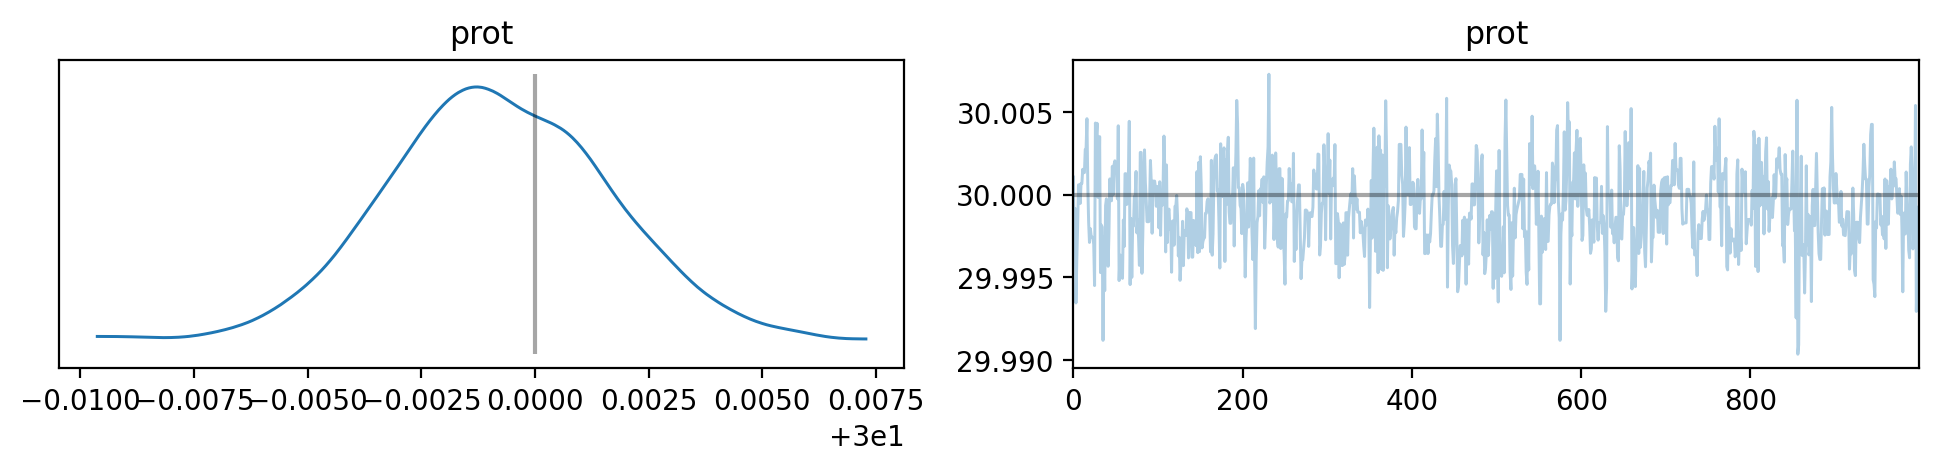

In [59]:
az.plot_trace(trace, var_names=['prot'],
              lines=[('prot', {}, pri.prot.eval())])

In [61]:
p = trace.posterior.sel(chain=0, draw=0)

In [70]:
map_ylms = []
f = theano.function([model.prot], ssp_model.sample_ylm_conditional(t, flux_obs, sigma_flux))

for c in trace.posterior.coords['chain']:
    for d in tqdm(trace.posterior.coords['draw']):
        p = trace.posterior.sel(chain=c, draw=d)
        map_ylms.append(f(p.prot))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [71]:
map_ylms = np.array(map_ylms)
map_ylms = np.reshape(map_ylms, (1, -1, 2*ssp.nlm))

In [72]:
map_ylms.shape

(1, 1000, 512)

And here is the posterior mean surface map:

/Users/sabina/Desktop/GitHub/starry_process/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


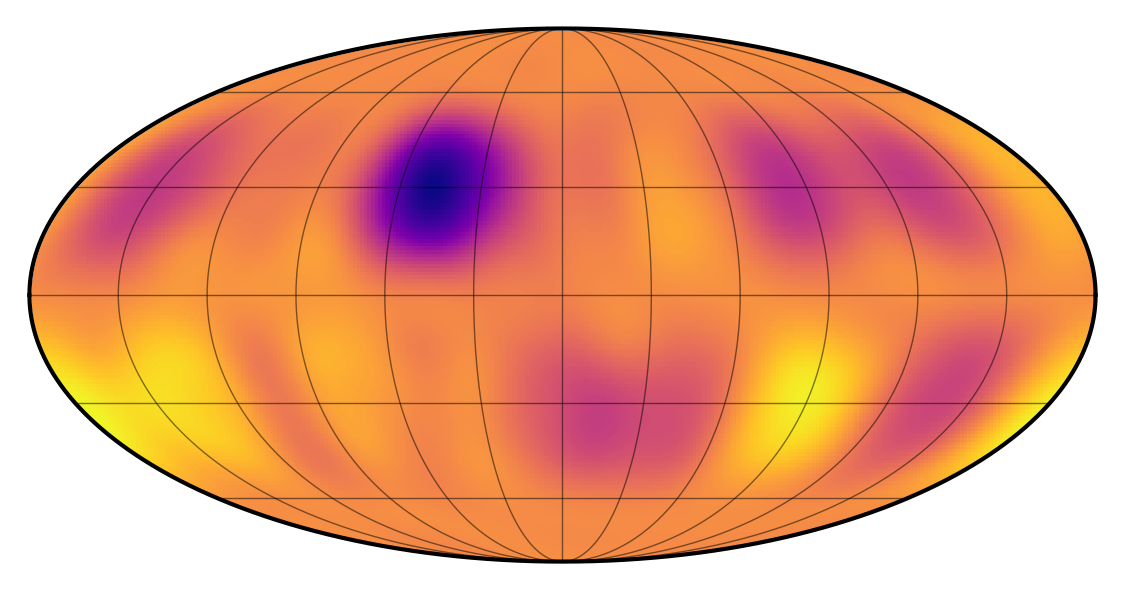

In [73]:
sp_model.visualize(np.mean(map_ylms[:,:,:ssp.nlm], axis=(0,1)))

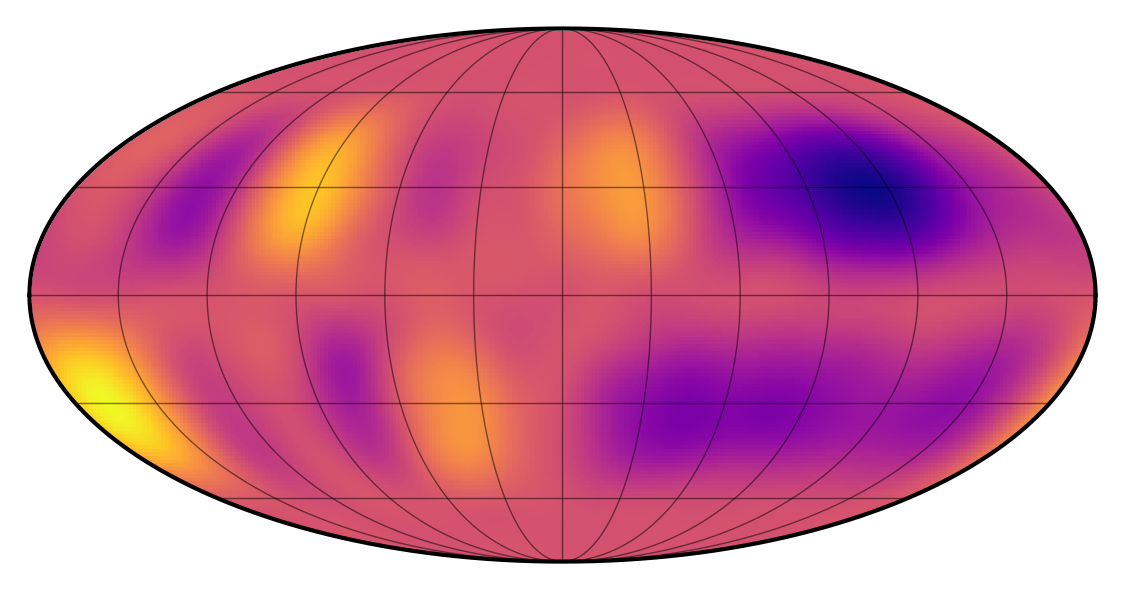

In [74]:
sp_model.visualize(np.mean(map_ylms[:,:,ssp.nlm:], axis=(0,1)))

And some draws from the posterior:

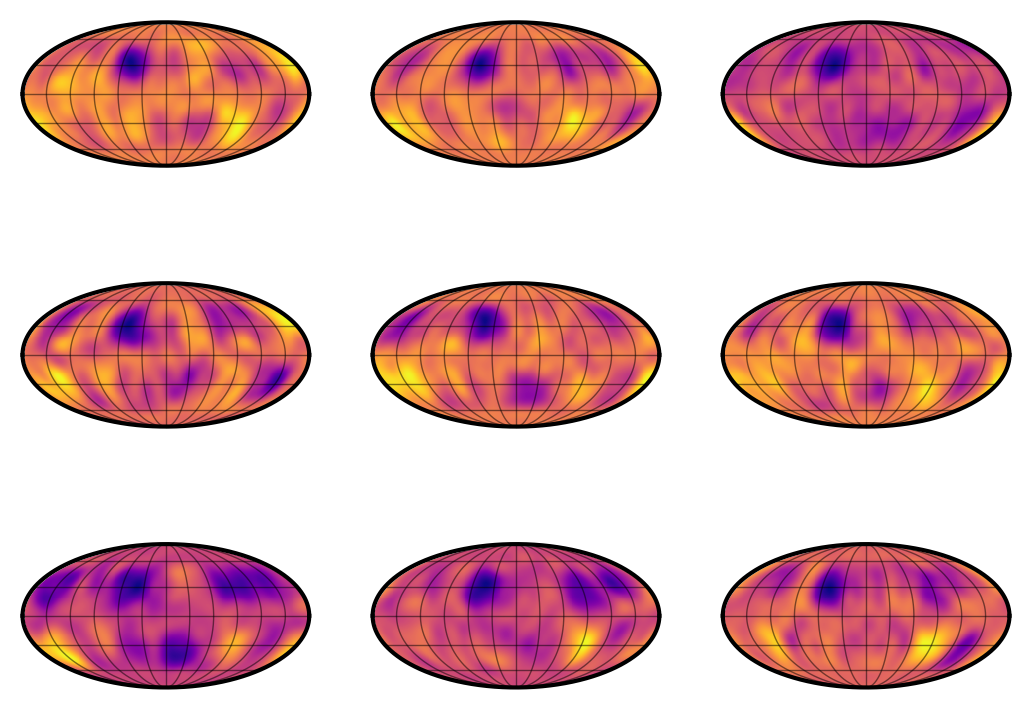

In [75]:
fig, axs = plt.subplots(3, 3)
for ax in axs.flatten():
    i = np.random.randint(map_ylms[:,:,:ssp.nlm].shape[0])
    j = np.random.randint(map_ylms[:,:,:ssp.nlm].shape[1])

    y = map_ylms[i,j,:ssp.nlm]

    sp_model.visualize(y, ax=ax)


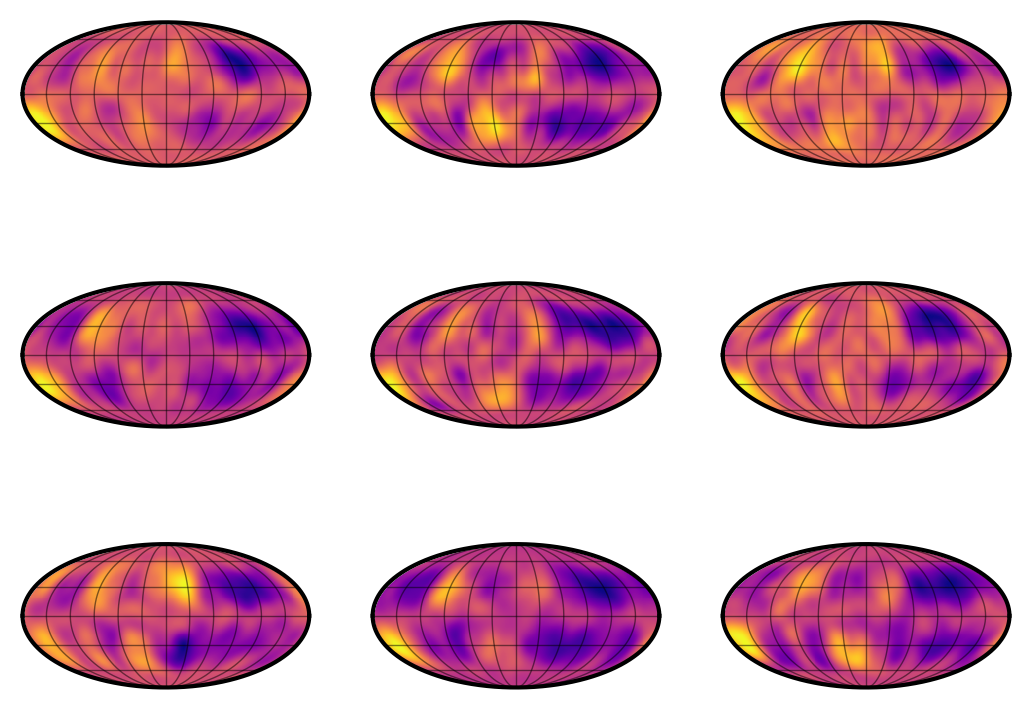

In [76]:
fig, axs = plt.subplots(3, 3)
for ax in axs.flatten():
    i = np.random.randint(map_ylms[:,:,ssp.nlm:].shape[0])
    j = np.random.randint(map_ylms[:,:,ssp.nlm:].shape[1])

    y = map_ylms[i,j,ssp.nlm:]

    sp_model.visualize(y, ax=ax)

Save the trace:

In [68]:
az.to_netcdf(trace, 'LinearSSP-trace.nc')

'LinearSSP-trace.nc'